# Movielens 영화 추천 시스템 2
---

### MovieLens 1M Dataset
- ratings.dat

 - 6,040 MovieLens users
 - 3,900 movies
 - 1,000,209 anonymous ratings : 평점(1~5)

- movies.dat

 - 영화 제목
 - 영화 장르

In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import datetime
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/project/exp16_MovieRecommendation/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


## EDA 
---


In [3]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

Dataset에는 6040명의 유저별, 3706개 영화에 대한 1,000,209건의 평점 정보(1점~5점)가 들어있다. 본프로젝트에서는 UserID를 세션 ID로, 영화를 추천 항목인 ItemID로 관리할것이다.

- UserId : 세션 아이디(한 세션에 여러 번의 클릭이 일어남)
- ItemId : 사용자가 클릭한 아이템 아이디
- Time : 클릭이 일어난 시간
- Rating : 원 데이터셋에서 영화에 대한 선호도 지표였으므로 세션중 상품에 대한 선호도를 표시하기위해 마우스커서의 체류시간으로 설정해서 분석해보면 좋을것 같다.  (rating 1 : 1초간 머뭄, rating 5: 5초간 머물렀다고 보고 사용자의 아이템에 대한 관심에 대한 지표) 

In [4]:
#컬럼 이름 변경
data.rename(columns = {'UserId' : 'SessionId'}, inplace = True)

In [5]:
# timestamp 시간 변환
def changeTime(df):
    #return datetime.datetime.fromtimestamp( df.Time ).strftime('%Y-%m-%d %H:%M:%S') #문자열변환
    return pd.to_datetime(df.Time, unit='s')

data.Time = data.apply(changeTime, axis=1 )

In [6]:
data.head()

,SessionId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43


### Session Length
사용자가 한 세션 동안 몇개의 아이템을 선택했는지 알아보자.

In [7]:
#Session Length
session_length = data.groupby('SessionId').size()
session_length.describe()

count    6040.000000
mean      165.597517
std       192.747029
min        20.000000
25%        44.000000
50%        96.000000
75%       208.000000
max      2314.000000
dtype: float64

LMS 에서 보았던 E-commerse 데이터셋을 영화데이터셋으로 대체해서 쓰려니 한세션당 클릭수가 너무 많아 매칭이 안되지만 **해비 유저 군집**이라는 가정하에 진행해보자.

평균적으로 사용자는 한 세션당 165개의 아이템을 선택했다. 최소 20개에서 최대 2314개 아이템을 선택했는데 최대치가 너무 크므로 전처리과정에서 제외시켜야할것 같다.


In [8]:
session_length.quantile(0.999)

1343.181000000005

분포상위 0.001의 데이터에 속하는 사용자중 한세션에 1343번의 클릭이 일어났다. imdb dataset의 아이템이 3706 인것을 감안하면 너무 큰 수치이다. 이런 데이터는 어떻게 해석하면좋을까? 사이트에서 전체 아이템을 조사하는 사용자? 아니면 매크로? 일단 일반적인 경우를 포함시키기위해 세션길이의 누적합을 알아보자.

In [9]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

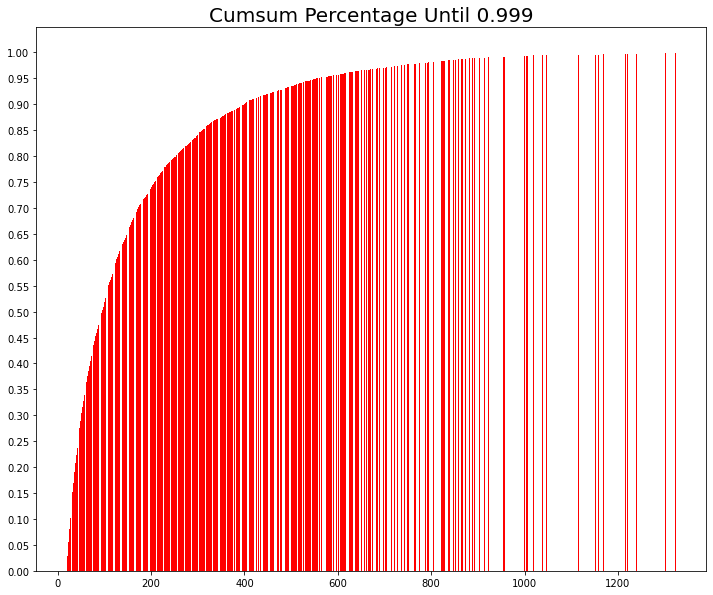

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
#plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [11]:
session_length.quantile(0.90)

400.0

상위 10%의 경우 클릭수가 너무 많다. 영화를 즐기기위한 용도로 사용하지 않는 집단으로 봐도 될것 같다. 추천시스템에 의해 영화를 선택하지않을것이므로 전처리시 세션길이 상위 10%는 제외하겠다.

### 데이터가 만들어진 시간
- 최근 소비트렌트를 학습시키기위해 최신 데이터를 사용해야하지만 데이터 자체가 너무 작으므로 데이터 분포를 살펴보고 사용할 구간을 알아보자.
 - 최근 1년 데이터 사용시 학습이 전혀 이루어 지지 않아 Dataset설정으로 다시돌아왔다.

In [12]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [13]:
data['months'] = data['Time'].dt.strftime('%Y-%m')

In [14]:
list_months= list(set(data.months))
list_months = sorted(list_months)
print(len(list_months), list_months)

35 ['2000-04', '2000-05', '2000-06', '2000-07', '2000-08', '2000-09', '2000-10', '2000-11', '2000-12', '2001-01', '2001-02', '2001-03', '2001-04', '2001-05', '2001-06', '2001-07', '2001-08', '2001-09', '2001-10', '2001-11', '2001-12', '2002-01', '2002-02', '2002-03', '2002-04', '2002-05', '2002-06', '2002-07', '2002-08', '2002-09', '2002-10', '2002-11', '2002-12', '2003-01', '2003-02']


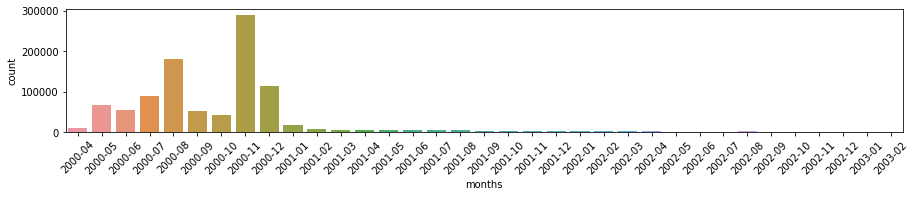

In [15]:
plt.figure(figsize=(15,5))
plt.subplot(211)
g = sns.countplot(data=data, x='months', order=list_months)
g.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.show()

데이터가 총 3년중 앞의 1년에 몰려있으므로 2000-04월부터 2001-04월 데이터로 학습을 진행해보겠다.

### 전처리
---
- Data Cleansing
 - 클릭수가 1인데이터 제외, 400 초과인 데이터 제외
 - 선택횟수가 적은 아이이템 제외 : 3미만

In [16]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, session_min, session_max, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, session_min, session_max)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, session_min, session_max):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[(session_len >= session_min) & (session_len <= session_max) ].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

data = cleanse_recursive(data, session_min=2, session_max=400, least_click=3)
data.head()

,SessionId,ItemId,Rating,Time,months
31,1,3186,4,2000-12-31 22:00:19,2000-12
22,1,1270,5,2000-12-31 22:00:55,2000-12
27,1,1721,4,2000-12-31 22:00:55,2000-12
37,1,1022,5,2000-12-31 22:00:55,2000-12
24,1,2340,3,2000-12-31 22:01:43,2000-12


In [17]:
month_last = oldest + datetime.timedelta(365)     # 처음 날짜로부터 365일 이후 날짜를 구한다.  
data = data[data['Time'] < month_last]   # 마지막달 이전데이터만 선택
data.tail()

,SessionId,ItemId,Rating,Time,months
1000124,6040,495,2,2000-07-28 23:59:42,2000-07
1000191,6040,3751,4,2000-07-28 23:59:42,2000-07
1000194,6040,1077,5,2000-07-28 23:59:59,2000-07
999972,6040,3168,4,2000-07-29 00:01:40,2000-07
999975,6040,3182,5,2001-03-10 03:41:22,2001-03


In [18]:
data['SessionId'].nunique(), data['ItemId'].nunique()

(5434, 3366)

전처리를 통해 SessionId 5434개, 아이템 3366개가 남았다.


### Train / Valid / Test split
---



2000-04월부터 2001-01월까지 데이터를 train set으로, 나머지 두달을 각각 valid set(2001-03월), test set(2001-04월)으로 쓰겠다.

In [19]:
def split_by_month(data: pd.DataFrame, month):    
    
    month_data = data[data['months']==month] 
    remain_data = data[data['months']!=month] 
    
    return remain_data, month_data

tr, test = split_by_month(data, '2001-04')
tr, val = split_by_month(tr, '2001-03')

In [20]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 587956
	 Sessions: 5434
	 Items: 3366
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2001-02-28 20:55:22

* valid Set Stats Info
	 Events: 2739
	 Sessions: 191
	 Items: 1259
	 First Time : 2001-03-01 03:16:03
	 Last Time : 2001-03-31 23:36:34

* test Set Stats Info
	 Events: 1429
	 Sessions: 143
	 Items: 797
	 First Time : 2001-04-01 02:35:55
	 Last Time : 2001-04-25 22:16:02



In [21]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)


save_path = data_path / 'processed_mv'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl') #객체를 파일로 피클링(직렬화저장)
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## Session-Parallel Mini-Batch
---

### SessionDataset class
- click_offsets : 세션이 시작되는 인덱스 값, 세션을 새로 인덱스 값 설정
- session_idx : 각 세션을 인덱싱한 np.array

In [22]:
class SessionDataset:
    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique()) # indexing to SessionId
    
    def get_click_offsets(self):
        """
        Return the indexes of the first click of each s}ession IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() +1, dtype=np.int32) #세션 겟수 +1 (최초 위치인 0을 추가)만큼  배열생성
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        
        return offsets

tr_dataset = SessionDataset(tr)
tr_dataset.df.head(5)

,SessionId,ItemId,Rating,Time,months,item_idx
31,1,3186,4,2000-12-31 22:00:19,2000-12,0
22,1,1270,5,2000-12-31 22:00:55,2000-12,1
27,1,1721,4,2000-12-31 22:00:55,2000-12,2
37,1,1022,5,2000-12-31 22:00:55,2000-12,3
24,1,2340,3,2000-12-31 22:01:43,2000-12,4


In [23]:
tr_dataset.df[50:54]

,SessionId,ItemId,Rating,Time,months,item_idx
32,1,1566,4,2001-01-06 23:38:50,2001-01,50
34,1,1907,4,2001-01-06 23:38:50,2001-01,51
25,1,48,5,2001-01-06 23:39:11,2001-01,52
130,2,1198,4,2000-12-31 21:28:44,2000-12,53


In [24]:
tr_dataset.click_offsets[:5]

array([  0,  53, 182, 233, 254], dtype=int32)

첫 세션의 범위는 item_idx 0~ 53까지이다. 54번째(인덱스로 53) 부터 새로운 세션이 시작된다고볼수있다.

### SessionDataLoader class
- SessionDataset 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스
- iter 메서드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 yield
- mask는 후에 RNN Cell State를 초기화하는데 사용

In [25]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.        
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        #print('initialize last_session:', last_session, 'b size:',self.batch_size, first_iters)
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished
    
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)

In [26]:
iter_ex = iter(tr_data_loader)

inputs, labels, mask =  next(iter_ex)

print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

inputs, labels, mask =  next(iter_ex)

print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 65 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []
Model Input Item Idx are : [ 1 54 62 24]
Label Item Idx are :       [  2  55 175  67]
Previous Masked Input Idx are []


## Modeling
---

###  Evaluation Metric 

- MRR(Mean Reciprocal Rank) : Reciprocal rank는 첫 번째로 등장하는 relevant한 아이템이 추천상 몇 번째에 위치하는지를 나타내는 지표로 
추천된 상대적인 위치에 따라서 점수를 차등하여 나타냄. 즉 상위에 관련 아이템을 추천시 점수가 높아진다.
- Recall@k : 전체 relevant한 아이템 중 추천된 아이템이 속한 비율이다. 실제 사용자가 선호하는 영화를 얼마나 포함시켰는지 나타낸다.

In [27]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0

def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### Model Architecture

In [28]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [29]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    #model.summary()
    return model

class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.ratings = tr['Rating'].unique()#
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k


### Model Training

In [30]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [31]:
val.shape, test.shape

((2739, 6), (1429, 6))

### 하이퍼파라미터 설정

- batch_size : validation 데이터셋 2739, test 데이터셋 1429 크기를 감안하여 배치사이즈를 설정
- hsz : GRU hidden state unit
- k : 추천시스템에 의해 추천되는 아이템 개수

In [48]:
# Model1 : batch_size=32,  hsz=16, k=20
args = Args(tr, val, test, batch_size=32, hsz=16, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model = create_model(args)
model.summary()

train_model(model, args)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(32, 1, 3366)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 16), (32, 16)]      162432    
_________________________________________________________________
dropout_4 (Dropout)          (32, 16)                  0         
_________________________________________________________________
dense_4 (Dense)              (32, 3366)                57222     
Total params: 219,654
Trainable params: 219,654
Non-trainable params: 0
_________________________________________________________________


Evaluation:  52%|█████▏    | 41/79 [00:06<00:06,  6.16it/s]


	 - Recall@20 epoch 1: 0.124238
	 - MRR@20    epoch 1: 0.030346



Evaluation:  52%|█████▏    | 41/79 [00:06<00:05,  6.56it/s]


	 - Recall@20 epoch 2: 0.201220
	 - MRR@20    epoch 2: 0.048878



Evaluation:  52%|█████▏    | 41/79 [00:06<00:05,  6.61it/s]


	 - Recall@20 epoch 3: 0.217226
	 - MRR@20    epoch 3: 0.056579



Evaluation:  52%|█████▏    | 41/79 [00:06<00:05,  6.67it/s]


	 - Recall@20 epoch 4: 0.226372
	 - MRR@20    epoch 4: 0.062838



Evaluation:  52%|█████▏    | 41/79 [00:06<00:05,  6.73it/s]

	 - Recall@20 epoch 5: 0.227134
	 - MRR@20    epoch 5: 0.065369



In [45]:
# Model 2 : batch_size=64,  hsz=32, k=20
args2 = Args(tr, val, test, batch_size=64, hsz=32, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model2 = create_model(args2)
train_model(model2, args2)

Evaluation:  28%|██▊       | 11/39 [00:03<00:08,  3.27it/s]


	 - Recall@20 epoch 1: 0.115057
	 - MRR@20    epoch 1: 0.028567



Evaluation:  28%|██▊       | 11/39 [00:03<00:07,  3.64it/s]


	 - Recall@20 epoch 2: 0.177557
	 - MRR@20    epoch 2: 0.054553



Evaluation:  28%|██▊       | 11/39 [00:03<00:07,  3.57it/s]


	 - Recall@20 epoch 3: 0.204545
	 - MRR@20    epoch 3: 0.066267



Evaluation:  28%|██▊       | 11/39 [00:03<00:08,  3.50it/s]


	 - Recall@20 epoch 4: 0.221591
	 - MRR@20    epoch 4: 0.073094



Evaluation:  28%|██▊       | 11/39 [00:02<00:07,  3.77it/s]

	 - Recall@20 epoch 5: 0.244318
	 - MRR@20    epoch 5: 0.078453



In [32]:
# Model 3 : batch_size=64,  hsz=32, k=10
args3 = Args(tr, val, test, batch_size=64, hsz=32, drop_rate=0.1, lr=0.001, epochs=5, k=10)
model3 = create_model(args3)
train_model(model3, args3)

Evaluation:  28%|██▊       | 11/39 [00:02<00:06,  4.39it/s]


	 - Recall@10 epoch 1: 0.072443
	 - MRR@10    epoch 1: 0.030810



Evaluation:  28%|██▊       | 11/39 [00:02<00:05,  5.07it/s]


	 - Recall@10 epoch 2: 0.123580
	 - MRR@10    epoch 2: 0.054870



Evaluation:  28%|██▊       | 11/39 [00:02<00:05,  5.37it/s]


	 - Recall@10 epoch 3: 0.149148
	 - MRR@10    epoch 3: 0.066417



Evaluation:  28%|██▊       | 11/39 [00:02<00:05,  5.47it/s]


	 - Recall@10 epoch 4: 0.151989
	 - MRR@10    epoch 4: 0.067549



Evaluation:  28%|██▊       | 11/39 [00:01<00:05,  5.57it/s]

	 - Recall@10 epoch 5: 0.151989
	 - MRR@10    epoch 5: 0.068133



In [52]:
# Model 4 : batch_size=64,  hsz=32, k=30
args4 = Args(tr, val, test, batch_size=64, hsz=32, drop_rate=0.1, lr=0.001, epochs=5, k=30)
model4 = create_model(args4)
train_model(model4, args4)


Evaluation:  28%|██▊       | 11/39 [00:04<00:11,  2.47it/s]


	 - Recall@30 epoch 1: 0.151989
	 - MRR@30    epoch 1: 0.030134



Evaluation:  28%|██▊       | 11/39 [00:04<00:10,  2.72it/s]


	 - Recall@30 epoch 2: 0.227273
	 - MRR@30    epoch 2: 0.056088



Evaluation:  28%|██▊       | 11/39 [00:04<00:10,  2.75it/s]


	 - Recall@30 epoch 3: 0.267045
	 - MRR@30    epoch 3: 0.067664



Evaluation:  28%|██▊       | 11/39 [00:03<00:09,  2.81it/s]


	 - Recall@30 epoch 4: 0.286932
	 - MRR@30    epoch 4: 0.072825



Evaluation:  28%|██▊       | 11/39 [00:03<00:09,  2.82it/s]

	 - Recall@30 epoch 5: 0.292614
	 - MRR@30    epoch 5: 0.076131



In [36]:
# Model 5 : batch_size=128,  hsz=64, k=30
args5 = Args(tr, val, test, batch_size=128, hsz=64, drop_rate=0.1, lr=0.001, epochs=5, k=30)
model5 = create_model(args5)
train_model(model5, args5)


Evaluation:   5%|▌         | 1/19 [00:01<00:18,  1.01s/it]


	 - Recall@30 epoch 1: 0.078125
	 - MRR@30    epoch 1: 0.016777



Evaluation:   5%|▌         | 1/19 [00:00<00:13,  1.32it/s]


	 - Recall@30 epoch 2: 0.125000
	 - MRR@30    epoch 2: 0.049099



Evaluation:   5%|▌         | 1/19 [00:00<00:13,  1.32it/s]


	 - Recall@30 epoch 3: 0.156250
	 - MRR@30    epoch 3: 0.064975



Evaluation:   5%|▌         | 1/19 [00:00<00:13,  1.35it/s]


	 - Recall@30 epoch 4: 0.148438
	 - MRR@30    epoch 4: 0.072786



Evaluation:   5%|▌         | 1/19 [00:00<00:14,  1.26it/s]

	 - Recall@30 epoch 5: 0.140625
	 - MRR@30    epoch 5: 0.072004



In [39]:
# Model 6 : batch_size=128,  hsz=64, k=10
args6 = Args(tr, val, test, batch_size=128, hsz=64, drop_rate=0.1, lr=0.001, epochs=5, k=10)
model6 = create_model(args6)
train_model(model6, args6)

Evaluation:   5%|▌         | 1/19 [00:00<00:10,  1.71it/s]


	 - Recall@10 epoch 1: 0.054688
	 - MRR@10    epoch 1: 0.011802



Evaluation:   5%|▌         | 1/19 [00:00<00:07,  2.54it/s]


	 - Recall@10 epoch 2: 0.085938
	 - MRR@10    epoch 2: 0.044379



Evaluation:   5%|▌         | 1/19 [00:00<00:06,  2.93it/s]


	 - Recall@10 epoch 3: 0.093750
	 - MRR@10    epoch 3: 0.041211



Evaluation:   5%|▌         | 1/19 [00:00<00:06,  2.84it/s]


	 - Recall@10 epoch 4: 0.109375
	 - MRR@10    epoch 4: 0.045452



Evaluation:   5%|▌         | 1/19 [00:00<00:05,  3.00it/s]

	 - Recall@10 epoch 5: 0.093750
	 - MRR@10    epoch 5: 0.048251



### Inference

In [34]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

In [49]:
# Test1 : batch_size=32,  hsz=16, k=20
test_model(model, args, test)

Evaluation:  48%|████▊     | 19/40 [00:02<00:03,  6.65it/s]

	 - Recall@20: 0.241776
	 - MRR@20: 0.058009



In [47]:
# Test2 : batch_size=64,  hsz=32, k=20
test_model(model2, args2, test)

Evaluation:  25%|██▌       | 5/20 [00:01<00:04,  3.72it/s]

	 - Recall@20: 0.228125
	 - MRR@20: 0.070201



In [35]:
# Test3 : batch_size=64,  hsz=32, k=10
test_model(model3, args3, test)

Evaluation:  25%|██▌       | 5/20 [00:01<00:04,  3.61it/s]

	 - Recall@10: 0.246875
	 - MRR@10: 0.070355



In [53]:
# Test4 : batch_size=64,  hsz=32, k=30
test_model(model4, args4, test)

Evaluation:  25%|██▌       | 5/20 [00:01<00:04,  3.49it/s]

	 - Recall@30: 0.206250
	 - MRR@30: 0.068793



In [38]:
# Test5 : batch_size=128,  hsz=64, k=30
test_model(model5, args5, test)

Evaluation:   0%|          | 0/10 [00:00<?, ?it/s]

	 - Recall@30: nan
	 - MRR@30: nan



In [40]:
# Test6 : batch_size=128,  hsz=64, k=10
test_model(model6, args6, test)

Evaluation:   0%|          | 0/10 [00:00<?, ?it/s]

	 - Recall@10: nan
	 - MRR@10: nan



## 정리.
---
- LMS와 데이터셋의 성격이 다른 데이터로 추천시스템을 만들면서 시행착오를 많이격었다. 일단 데이터 사이즈가 작아서 하이퍼파라미터 튜닝으로 올릴수있는 성능의 한계가 있었다. 

- test 결과 
 - batch_size=128,  hsz=64 인경우 테스트가 되지않았다.
 - batch_size=64,  hsz=32, k=10 에서 Recall 과 MRR 지수 모두 성능이 좋았다.
```
Recall@10: 0.246875
MRR@10: 0.070355
```

- Rating 데이터의 반영(마우스 커서의 체류시간)
 - 데이터셋에 Rating 데이터가 포함되었지만 예측시 반영되지않은 것 같다. input과 label에 해당하는 item 정보만이 모델에 들어갔으므로 추천을 위해 rating을 반영하는 방법을 더 연구해보아야하겠다.

## Reference
- https://zzaebok.github.io/recommender_system/metrics/rec_metrics/
